# Pigskin Playcaller

### Author: David Shin

### Overview

Every year, data and analytics in sports continues to expand. With the union of my personal interest in the sport of Football and the need for an analytical approach to the game, I have decided to create a model that will recommend a defensive coverage scheme against the offense. Data science takes an unbiased approach to the sport and can provide calculated decision making to coaches and players. My data comes from a Kaggle contest where the data is provided by the NFL. Also used was a dataset from Telemetry Sports that looks at the coverage schemes used by the defense. The last piece of data was from nflfastR that provides weather condition and other variables for the events.

https://www.kaggle.com/c/nfl-big-data-bowl-2021/data

https://twitter.com/nflfastr?lang=en

## Import Mods/Libraries

In [1]:
import pandas as pd
import glob
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection
import streamlit as st
# path = r'C:\Users\admin\Documents\Flatiron\capstone\pigskin\data\weekly' # use your path
# all_files = glob.glob(path + "/*.csv")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# df_weekly = pd.concat(li, axis=0, ignore_index=True)

## Data Loading and Cleaning

In [2]:
#Loading Data
players = pd.read_csv('data/players.csv')
df_games = pd.read_csv('data/weekly/week1.csv')
df_plays = pd.read_csv('data/plays.csv')
df_fo = pd.read_csv('data/2018fo.csv')
df_coverages = pd.read_csv('data/coverages_week1.csv')
df_fastr = data = pd.read_csv(
    'https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_' \
    + str(2018) + '.csv.gz?raw=True',compression='gzip', low_memory=False)

In [3]:
pd.set_option('display.max_columns', None)
df_fastr.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assi

In [4]:
#View Datatypes of all Columns
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986022 entries, 0 to 986021
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           986022 non-null  object 
 1   x              986022 non-null  float64
 2   y              986022 non-null  float64
 3   s              986022 non-null  float64
 4   a              986022 non-null  float64
 5   dis            986022 non-null  float64
 6   o              919109 non-null  float64
 7   dir            919109 non-null  float64
 8   event          986022 non-null  object 
 9   nflId          919109 non-null  float64
 10  displayName    986022 non-null  object 
 11  jerseyNumber   919109 non-null  float64
 12  position       919109 non-null  object 
 13  frameId        986022 non-null  int64  
 14  team           986022 non-null  object 
 15  gameId         986022 non-null  int64  
 16  playId         986022 non-null  int64  
 17  playDirection  986022 non-nul

In [5]:
#View Datatypes of all Columns
df_plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  19239 non-null  int64  
 1   playId                  19239 non-null  int64  
 2   playDescription         19239 non-null  object 
 3   quarter                 19239 non-null  int64  
 4   down                    19239 non-null  int64  
 5   yardsToGo               19239 non-null  int64  
 6   possessionTeam          19239 non-null  object 
 7   playType                19239 non-null  object 
 8   yardlineSide            18985 non-null  object 
 9   yardlineNumber          19239 non-null  int64  
 10  offenseFormation        19098 non-null  object 
 11  personnelO              19210 non-null  object 
 12  defendersInTheBox       19177 non-null  float64
 13  numberOfPassRushers     18606 non-null  float64
 14  personnelD              19210 non-null

In [6]:
df_coverages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gameId    1028 non-null   int64 
 1   playId    1028 non-null   int64 
 2   coverage  1028 non-null   object
dtypes: int64(2), object(1)
memory usage: 24.2+ KB


In [7]:
df_coverages.head()

,gameId,playId,coverage
0,2018091000,1101,Cover 1 Man
1,2018091000,1005,Cover 1 Man
2,2018091000,287,Cover 1 Man
3,2018091000,3151,Cover 2 Zone
4,2018091000,1029,Cover 2 Zone


In [8]:
#Scale EPA to 0-1 min max
df_plays['scaled_epa'] = (df_plays['epa'] - min(df_plays['epa'])) / (max(df_plays['epa']) - min(df_plays['epa']))

EPA is our target variable for this project. EPA stands for Expected Points Added. Expected Points Added is calculated by contrasting the situation of the play at the start of play and the end of the play. EPA takes into account variables such as  what down, the distance to first down, and the field position. Essentially, EPA tries to calculate how much each play contributed to the total score of the game. In order to better understand and normalize this variable, it has been scaled from 0-1 with a min-max scaling method. We are scaling EPA here to a 0-1 scale to make it easier to understand the impact of each play.

### Merge Datasets 

In [9]:
df_plays_coverage = pd.merge(df_plays,df_coverages,left_on=['gameId','playId'],right_on=['gameId','playId'])
df_plays_final = pd.merge(df_plays_coverage,df_games,left_on=['gameId','playId'],right_on=['gameId','playId'])
#df_plays_final = pd.merge(df_plays_coverage,df_games,on='Id')
#df_plays_final

In [10]:
df_plays_final.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI,scaled_epa,coverage,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,playDirection,route
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,left,NaN
1,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,left,NaN
2,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,left,HITCH
3,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,left,NaN
4,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,left,HITCH


In [11]:
df_plays_final.describe()

,gameId,playId,quarter,down,yardsToGo,yardlineNumber,defendersInTheBox,numberOfPassRushers,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber,offensePlayResult,playResult,epa,scaled_epa,x,y,s,a,dis,o,dir,nflId,jerseyNumber,frameId
count,9.805180e+05,980518.000000,980518.000000,980518.000000,980518.000000,980518.000000,977463.000000,939943.000000,939215.000000,939215.000000,939215.000000,980518.000000,980518.000000,980518.000000,980518.000000,980518.000000,980518.000000,980518.000000,980518.000000,980518.000000,913968.000000,913968.000000,9.139680e+05,913968.000000,980518.000000
mean,2.018091e+09,2261.416165,2.673940,1.931272,9.137379,29.488715,6.042063,4.155605,11.851541,11.096749,59.202991,6.513751,6.726907,-0.141795,0.573499,58.996372,26.804296,3.188814,2.014634,0.323511,179.575290,181.169083,2.367482e+06,37.732364,35.424490
std,9.377609e+01,1277.498016,1.145016,0.848046,4.201504,12.219461,0.948985,0.768557,11.586010,10.007374,23.827352,10.877093,11.811574,1.880062,0.091419,24.958730,11.201647,2.843571,1.690667,0.307014,100.721187,102.968656,6.176163e+05,24.946628,23.630264
min,2.018091e+09,58.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,11.000000,-12.000000,-70.000000,-9.325884,0.126916,-5.980000,-11.740000,0.000000,0.000000,0.000000,0.000000,0.000000,3.060000e+02,1.000000,1.000000
25%,2.018091e+09,1188.000000,2.000000,1.000000,7.000000,20.000000,6.000000,4.000000,3.000000,3.000000,39.000000,0.000000,0.000000,-0.872290,0.537978,39.980000,19.000000,0.850000,0.740000,0.090000,89.890000,91.460000,2.533040e+06,20.000000,17.000000
50%,2.018091e+09,2288.000000,3.000000,2.000000,10.000000,30.000000,6.000000,4.000000,10.000000,9.000000,58.000000,3.000000,4.000000,-0.218672,0.569761,59.160000,26.850000,2.790000,1.750000,0.280000,177.530000,181.270000,2.552255e+06,29.000000,33.000000
75%,2.018091e+09,3299.000000,4.000000,3.000000,10.000000,40.000000,7.000000,4.000000,20.000000,17.000000,80.000000,10.000000,11.000000,0.909062,0.624597,78.230000,34.710000,4.960000,2.940000,0.500000,269.860000,271.300000,2.556480e+06,53.000000,50.000000
max,2.018091e+09,5511.000000,5.000000,4.000000,30.000000,50.000000,10.000000,8.000000,48.000000,47.000000,109.000000,75.000000,75.000000,6.477970,0.895389,128.380000,62.750000,27.370000,58.330000,7.120000,360.000000,360.000000,2.561485e+06,99.000000,172.000000


In [12]:
#Use only data of scenario of when ball is snapped

df_plays_final = df_plays_final[df_plays_final.event == 'ball_snap']
df_plays_final

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI,scaled_epa,coverage,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,playDirection,route
140,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:15.599Z,91.74,26.67,0.00,0.00,0.01,277.41,235.01,ball_snap,310.0,Matt Ryan,2.0,QB,11,away,left,NaN
141,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:15.599Z,88.89,36.50,0.01,0.01,0.00,104.49,36.45,ball_snap,79848.0,Malcolm Jenkins,27.0,SS,11,home,left,NaN
142,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:15.599Z,91.36,44.14,0.00,0.01,0.02,289.53,49.86,ball_snap,2495454.0,Julio Jones,11.0,WR,11,away,left,HITCH
143,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:15.599Z,86.47,22.03,0.18,0.07,0.01,71.89,82.30,ball_snap,2495613.0,Corey Graham,24.0,FS,11,home,left,NaN
144,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:15.599Z,90.78,36.16,0.00,0.00,0.00,259.19,294.93,ball_snap,2533040.0,Mohamed Sanu,12.0,WR,11,away,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979692,2018091001,1181,(12:24) (Shotgun) J.Goff pass incomplete deep ...,2,2,10,LA,play_type_unknown,LA,19,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,NaN,"4 DL, 2 LB, 5 DB",NaN,NaN,NaN,NaN,NaN,DPI,OAK 22,I,0,37,3.036488,True,0.728045,Cover 4 Zone,2018-09-11T03:12:23.000Z,23.82,23.95,0.10,0.26,0.02,92.64,210.70,ball_snap,2555334.0,Jared Goff,16.0,QB,11,away,right,NaN
979702,2018091001,1181,(12:24) (Shotgun) J.Goff pass incomplete deep ...,2,2,10,LA,play_type_unknown,LA,19,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,NaN,"4 DL, 2 LB, 5 DB",NaN,NaN,NaN,NaN,NaN,DPI,OAK 22,I,0,37,3.036488,True,0.728045,Cover 4 Zone,2018-09-11T03:12:23.000Z,27.93,42.98,0.00,0.00,0.00,97.06,115.31,ball_snap,2555364.0,Tyler Higbee,89.0,TE,11,away,right,NaN
979712,2018091001,1181,(12:24) (Shotgun) J.Goff pass incomplete deep ...,2,2,10,LA,play_type_unknown,LA,19,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,NaN,"4 DL, 2 LB, 5 DB",NaN,NaN,NaN,NaN,NaN,DPI,OAK 22,I,0,37,3.036488,True,0.728045,Cover 4 Zone,2018-09-11T03:12:23.000Z,26.77,31.22,0.00,0.00,0.00,95.99,117.57,ball_snap,2557898.0,Cooper Kupp,18.0,WR,11,away,right,NaN
979722,2018091001,1181,(12:24) (Shotgun) J.Goff pass incomplete deep ...,2,2,10,LA,play_type_unknown,LA,19,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,NaN,"4 DL, 2 LB, 5 DB",NaN,NaN,NaN,NaN,NaN,DPI,OAK 22,I,0,37,3.036488,True,0.728045,Cover 4 Zone,2018-09-11T03:12:23.000Z,29.64,42.99,0.06,0.29,0.01,277.49,3.36,ball_snap,2558062.0,Gareon Conley,21.0,CB,11,home,right,NaN


### Drop Any Duplicate Rows

In [13]:
df_plays_final = df_plays_final.drop_duplicates(subset='playId', keep="first")

In [14]:
# View Columns
df_plays_final.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI',
       'scaled_epa', 'coverage', 'time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir',
       'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId',
       'team', 'playDirection', 'route'],
      dtype='object')

In [15]:
df_plays_new = pd.merge(df_plays_final,df_fastr[['old_game_id','play_id','weather', 'roof', 'surface','temp','wind']], how = 'left',left_on=['gameId','playId'],right_on=['old_game_id','play_id'])

In [16]:
df_plays_new.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI,scaled_epa,coverage,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,playDirection,route,old_game_id,play_id,weather,roof,surface,temp,wind
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,0.593125,Cover 3 Zone,2018-09-07T01:07:15.599Z,91.74,26.67,0.00,0.00,0.01,277.41,235.01,ball_snap,310.0,Matt Ryan,2.0,QB,11,away,left,NaN,2018090600,75,"Cloudy Temp: 81° F, Humidity: 71%, Wind: NNW 8...",outdoors,grass,81.0,8.0
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False,0.562287,Cover 3 Zone,2018-09-07T01:09:10.700Z,50.61,29.71,0.00,0.00,0.01,267.52,171.48,ball_snap,310.0,Matt Ryan,2.0,QB,11,away,left,NaN,2018090600,146,"Cloudy Temp: 81° F, Humidity: 71%, Wind: NNW 8...",outdoors,grass,81.0,8.0
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False,0.546221,Cover 3 Zone,2018-09-07T01:09:51.599Z,54.56,29.67,0.00,0.00,0.00,277.89,274.70,ball_snap,310.0,Matt Ryan,2.0,QB,11,away,left,NaN,2018090600,168,"Cloudy Temp: 81° F, Humidity: 71%, Wind: NNW 8...",outdoors,grass,81.0,8.0
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False,0.728582,Cover 3 Zone,2018-09-07T01:10:35.599Z,54.17,29.61,0.03,0.38,0.00,286.54,67.43,ball_snap,310.0,Matt Ryan,2.0,QB,11,away,left,NaN,2018090600,190,"Cloudy Temp: 81° F, Humidity: 71%, Wind: NNW 8...",outdoors,grass,81.0,8.0
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.0,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False,0.539438,Cover 0 Man,2018-09-07T01:12:38.500Z,15.87,23.48,0.09,0.10,0.01,286.80,286.09,ball_snap,310.0,Matt Ryan,2.0,QB,11,away,left,NaN,2018090600,256,"Cloudy Temp: 81° F, Humidity: 71%, Wind: NNW 8...",outdoors,grass,81.0,8.0


In [17]:
df_plays_new.drop(['playDirection','gameId', 'playId', 'playDescription', 'quarter', 'possessionTeam', 'playType','yardlineSide','yardlineNumber','preSnapVisitorScore','preSnapHomeScore','gameClock','absoluteYardlineNumber','penaltyCodes','penaltyJerseyNumbers','passResult','offensePlayResult','playResult','epa','isDefensivePI','time','x','y','s','a','dis','o','dir','event','nflId','displayName','jerseyNumber','position','frameId','team','gameId','typeDropback','old_game_id','weather'], axis=1, inplace=True)
df_plays_new

,down,yardsToGo,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,scaled_epa,coverage,route,play_id,roof,surface,temp,wind
0,1,15,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",0.593125,Cover 3 Zone,NaN,75,outdoors,grass,81.0,8.0
1,1,10,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",0.562287,Cover 3 Zone,NaN,146,outdoors,grass,81.0,8.0
2,2,10,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0.546221,Cover 3 Zone,NaN,168,outdoors,grass,81.0,8.0
3,3,10,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",0.728582,Cover 3 Zone,NaN,190,outdoors,grass,81.0,8.0
4,3,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",0.539438,Cover 0 Man,NaN,256,outdoors,grass,81.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,2,15,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,NaN,"4 DL, 2 LB, 5 DB",0.610642,Cover 1 Man,NaN,3605,outdoors,grass,81.0,9.0
919,1,10,EMPTY,"1 RB, 3 TE, 1 WR",6.0,NaN,"3 DL, 3 LB, 5 DB",0.596362,Cover 1 Man,NaN,2303,dome,fieldturf,NaN,NaN
920,1,10,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,NaN,"3 DL, 3 LB, 5 DB",0.595674,Cover 2 Zone,NaN,2904,dome,fieldturf,NaN,NaN
921,2,13,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,NaN,"3 DL, 3 LB, 5 DB",0.657960,Cover 2 Zone,NaN,741,outdoors,grass,69.0,10.0


In [18]:
df_plays_new['roof'].value_counts()

outdoors    642
closed      147
dome        134
Name: roof, dtype: int64

## Exploratory Data Analysis

First, we want to take a look at the offensive side of the ball, since these are the features we are going to use to predict our target variable. It's important to see which formations are mostly on offense and with which personnel. 

Breaking down the types of formations used on offense, 

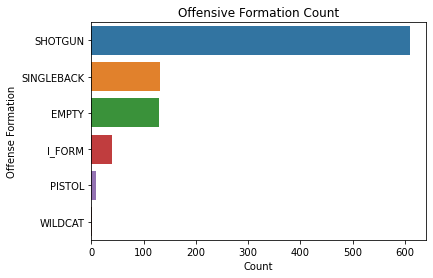

In [19]:
# Breakdown of Playtypes
sns.barplot(y=df_plays_final['offenseFormation'].value_counts().index,x=df_plays_final['offenseFormation'].value_counts())
plt.xlabel("Count")
plt.ylabel("Offense Formation")
plt.title("Offensive Formation Count");

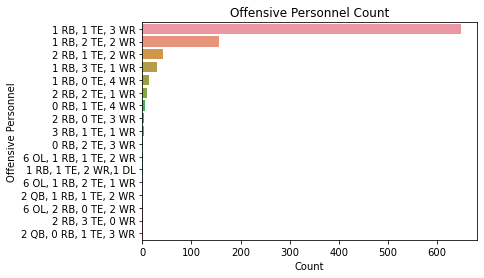

In [20]:
sns.barplot(y=df_plays_final['personnelO'].value_counts().index,x=df_plays_final['personnelO'].value_counts(),orient='h')
plt.xlabel("Count")
plt.ylabel("Offensive Personnel")
plt.title("Offensive Personnel Count");

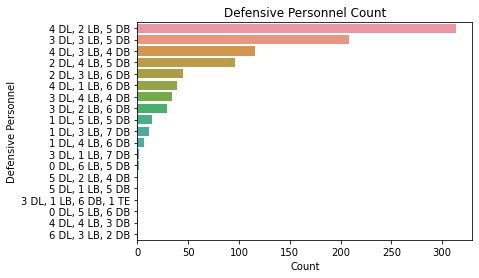

In [21]:
# Breakdown of Defensive Personnel
sns.barplot(y=df_plays_final['personnelD'].value_counts().index,x=df_plays_final['personnelD'].value_counts(),orient='h')
plt.xlabel("Count")
plt.ylabel("Defensive Personnel")
plt.title("Defensive Personnel Count");

I was interested to see if coverages were all similar in terms of EPA. At first glance, it appears that there's very little difference in average EPA based off the coverage. It would almost make sense to just say use a "Prevent Zone" coverage all the time. However, once we add in factors such as what down the plays were, the EPA numbers begin to change. This shows that depending on the circumstance, we cannot just blindly choose a Prevent Zone. Our data also shows that prevent zone was rarely used in our dataset. 

In [22]:
#Average EPA by Coverage
df_plays_final.groupby(['coverage'])['scaled_epa'].agg(['mean'])

,mean
coverage,
Cover 0 Man,0.568086
Cover 1 Man,0.574977
Cover 2 Man,0.570613
Cover 2 Zone,0.578073
Cover 3 Zone,0.572323
Cover 4 Zone,0.579605
Cover 6 Zone,0.572171
Prevent Zone,0.524001


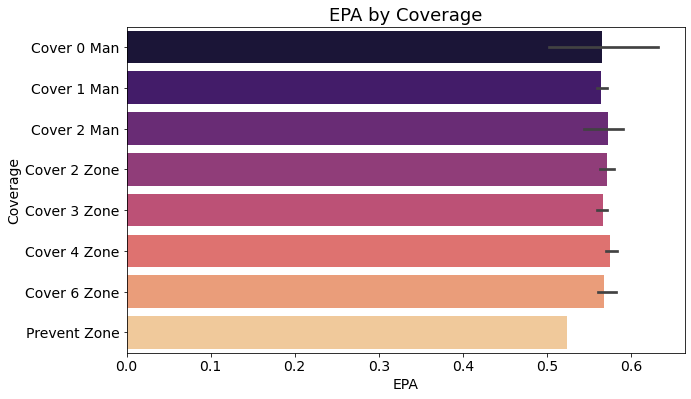

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['coverage'].sort_values(), x=df_plays_final['scaled_epa'], estimator=np.median, palette="magma")
plt.xlabel("EPA", fontdict={'fontsize':14});
plt.ylabel("Coverage", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("EPA by Coverage", fontdict={'fontsize':18});

In [24]:
#Average EPA by Coverage
df_plays_final.groupby(['coverage','down'])['scaled_epa'].agg(['mean'])

mean
coverage     down          
Cover 0 Man  1     0.568424
             2     0.553261
             3     0.581619
             4     0.556150
Cover 1 Man  1     0.578427
             2     0.575069
             3     0.578078
             4     0.458523
Cover 2 Man  1     0.592692
             2     0.575673
             3     0.556623
Cover 2 Zone 1     0.577799
             2     0.591420
             3     0.563388
             4     0.445754
Cover 3 Zone 1     0.579439
             2     0.571642
             3     0.564951
             4     0.461346
Cover 4 Zone 1     0.592618
             2     0.583366
             3     0.553885
             4     0.571388
Cover 6 Zone 1     0.602282
             2     0.547043
             3     0.577035
             4     0.404880
Prevent Zone 1     0.524001

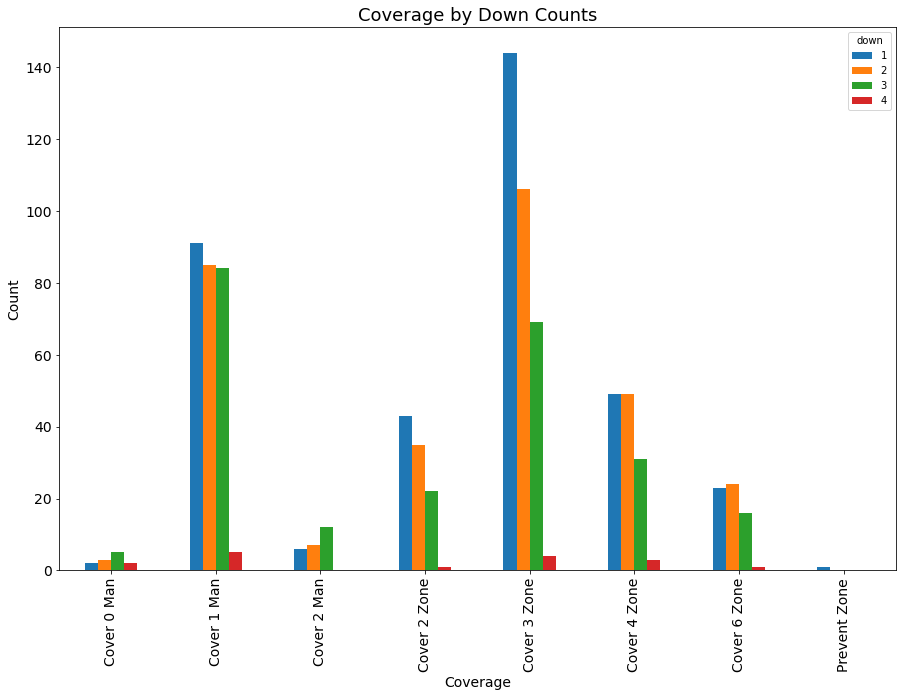

In [25]:
df_plot = df_plays_final.groupby(['coverage', 'down']).size().unstack(level=1)
df_plot.plot(kind = 'bar',figsize=(15,10))
plt.xlabel("Coverage", fontdict={'fontsize':14});
plt.ylabel("Count", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Coverage by Down Counts", fontdict={'fontsize':18});

For the below, I wanted to see if specific coverages were tied to specific offensive personnel schemes, that way it would be easier to develop a recommendation. Personnel breakdowns are specifically just the count of players by position on the field. Defenses can run different types of players in order to counteract the offense. For example, if they believe a passing play is incoming, the defense can employ more DB's (Defensive Backs) at the cost of less linebackers. In other words, if the defense used Cover 2 Man, do they specifically run 2 DL, 4 LB, 5 DB? However, it looks like from the below, there are issues with that and teams run multiple personnel schemes with defensive coverages. For our initial MVP, we will work with finding out best coverage.

In [26]:
#Viewing EPA by Personnel and Yardage Sitautions
pd.set_option("display.max_rows", None, "display.max_columns", None)
df_plays_final.groupby(['coverage','personnelD'])['gameId'].agg(['count'])

count
coverage     personnelD                   
Cover 0 Man  3 DL, 3 LB, 5 DB            1
             3 DL, 4 LB, 4 DB            2
             4 DL, 1 LB, 6 DB            2
             4 DL, 2 LB, 5 DB            4
             4 DL, 3 LB, 4 DB            2
             6 DL, 3 LB, 2 DB            1
Cover 1 Man  0 DL, 5 LB, 6 DB            1
             0 DL, 6 LB, 5 DB            1
             1 DL, 3 LB, 7 DB            1
             1 DL, 4 LB, 6 DB            1
             1 DL, 5 LB, 5 DB            6
             2 DL, 3 LB, 6 DB           18
             2 DL, 4 LB, 5 DB           28
             3 DL, 2 LB, 6 DB            5
             3 DL, 3 LB, 5 DB           63
             3 DL, 4 LB, 4 DB           13
             4 DL, 1 LB, 6 DB           10
             4 DL, 2 LB, 5 DB           78
             4 DL, 3 LB, 4 DB           38
             4 DL, 4 LB, 3 DB            1
Cover 2 Man  1 DL, 3 LB, 7 DB            3
             2 DL, 3 LB, 6 DB            2
             2 DL, 4 LB, 5 DB            2
             3 DL, 2 LB, 6 DB            3
             3 DL, 3 LB, 5 DB            8
             4 DL, 2 LB, 5 DB            7
Cover 2 Zone 1 DL, 4 LB, 6 DB            2
             1 DL, 5 LB, 5 DB            1
             2 DL, 3 LB, 6 DB            4
             2 DL, 4 LB, 5 DB            7
             3 DL, 2 LB, 6 DB            7
             3 DL, 3 LB, 5 DB           30
             3 DL, 4 LB, 4 DB            5
             4 DL, 2 LB, 5 DB           31
             4 DL, 3 LB, 4 DB           13
             5 DL, 1 LB, 5 DB            1
Cover 3 Zone 0 DL, 6 LB, 5 DB            1
             1 DL, 3 LB, 7 DB            3
             1 DL, 4 LB, 6 DB            3
             1 DL, 5 LB, 5 DB            3
             2 DL, 3 LB, 6 DB           11
             2 DL, 4 LB, 5 DB           43
             3 DL, 1 LB, 7 DB            1
             3 DL, 2 LB, 6 DB            7
             3 DL, 3 LB, 5 DB           71
             3 DL, 4 LB, 4 DB            7
             4 DL, 1 LB, 6 DB           17
             4 DL, 2 LB, 5 DB          119
             4 DL, 3 LB, 4 DB           36
             5 DL, 2 LB, 4 DB            1
Cover 4 Zone 1 DL, 3 LB, 7 DB            2
             1 DL, 5 LB, 5 DB            1
             2 DL, 3 LB, 6 DB            9
             2 DL, 4 LB, 5 DB            9
             3 DL, 1 LB, 7 DB            1
             3 DL, 2 LB, 6 DB            3
             3 DL, 3 LB, 5 DB           21
             3 DL, 4 LB, 4 DB            2
             4 DL, 1 LB, 6 DB            9
             4 DL, 2 LB, 5 DB           57
             4 DL, 3 LB, 4 DB           18
Cover 6 Zone 1 DL, 3 LB, 7 DB            2
             1 DL, 5 LB, 5 DB            3
             2 DL, 3 LB, 6 DB            1
             2 DL, 4 LB, 5 DB            7
             3 DL, 2 LB, 6 DB            4
             3 DL, 3 LB, 5 DB           14
             3 DL, 4 LB, 4 DB            5
             4 DL, 1 LB, 6 DB            1
             4 DL, 2 LB, 5 DB           18
             4 DL, 3 LB, 4 DB            9
Prevent Zone 3 DL, 1 LB, 6 DB, 1 TE      1

In [27]:
#Viewing EPA by Personnel and Yardage Sitautions
pd.set_option("display.max_rows", 101)
df_plays_final.groupby(['personnelD','yardsToGo'])['scaled_epa'].agg(['mean'])

mean
personnelD       yardsToGo          
0 DL, 5 LB, 6 DB 7          0.499642
0 DL, 6 LB, 5 DB 7          0.486291
                 11         0.489234
1 DL, 3 LB, 7 DB 3          0.515614
                 4          0.404880
...                              ...
4 DL, 3 LB, 4 DB 23         0.578292
4 DL, 4 LB, 3 DB 1          0.640030
5 DL, 1 LB, 5 DB 9          0.662653
5 DL, 2 LB, 4 DB 13         0.537468
6 DL, 3 LB, 2 DB 1          0.539438

[163 rows x 1 columns]

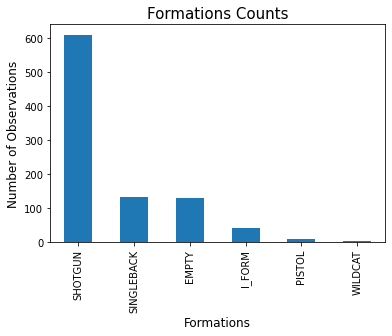

In [28]:
#Number of times Offensive Formation used
chart = df_plays_final['offenseFormation'].value_counts().plot(kind='bar');
chart.set_title('Formations Counts', fontsize=15);
chart.set_ylabel('Number of Observations', fontsize=12);
chart.set_xlabel('Formations', fontsize=12);

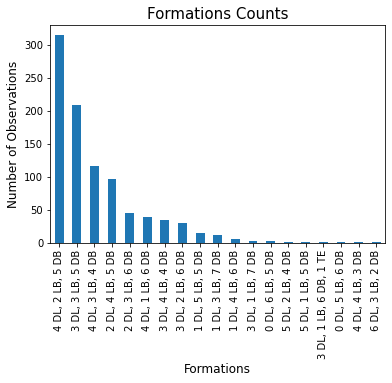

In [29]:
chart = df_plays_final['personnelD'].value_counts().plot(kind='bar');
chart.set_title('Formations Counts', fontsize=15);
chart.set_ylabel('Number of Observations', fontsize=12);
chart.set_xlabel('Formations', fontsize=12);

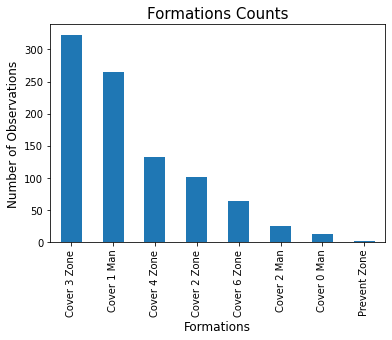

In [30]:
chart = df_plays_final['coverage'].value_counts().plot(kind='bar');
chart.set_title('Formations Counts', fontsize=15);
chart.set_ylabel('Number of Observations', fontsize=12);
chart.set_xlabel('Formations', fontsize=12);

Cover 3 Zone is one of the most popular formations in football. It is also one of the most basic coverages in football. In years prior, people thought it was elementary and used mainly for high school football, however, the Seattle Seahawks popularized this coverage scheme. The coverage is used frequently because it is balanced against both the run and pass offense. 

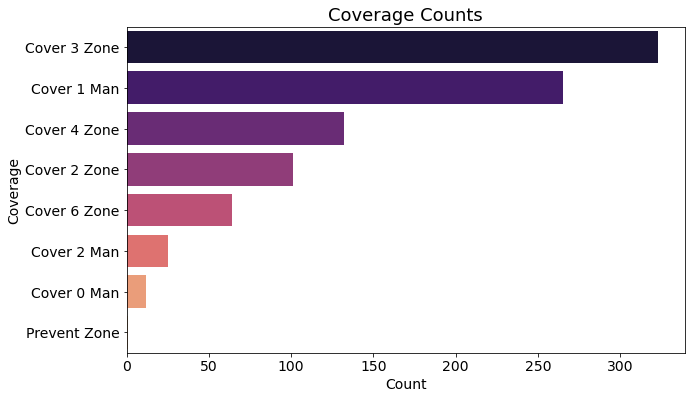

In [31]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['coverage'].value_counts().index, x=df_plays_final['coverage'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("Count", fontdict={'fontsize':14});
plt.ylabel("Coverage", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Coverage Counts", fontdict={'fontsize':18});

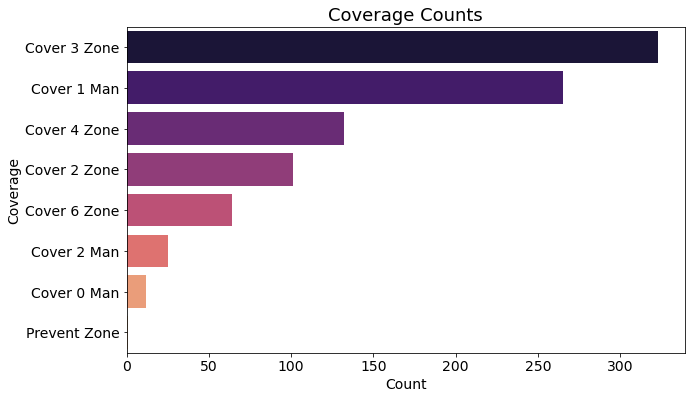

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['coverage'].value_counts().index, x=df_plays_final['coverage'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("Count", fontdict={'fontsize':14});
plt.ylabel("Coverage", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Coverage Counts", fontdict={'fontsize':18});

From below, we can see the commonly used defensive personnel scheme is a 4-2-5 or (4 DB, 2 LB, 5 DB). One of the biggest strengths of this defensive personnel is that it employs five defensive backs. With 5 defensive backs, your defense is able to be versatile in stopping the run and applying pressue to prevent the pass.

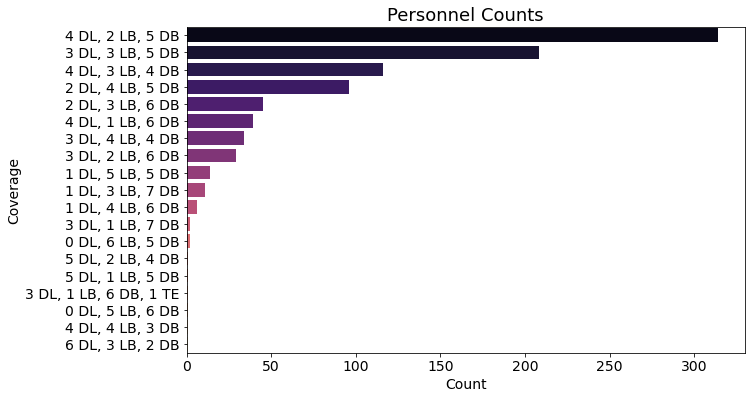

In [33]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['personnelD'].value_counts().index, x=df_plays_final['personnelD'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("Count", fontdict={'fontsize':14});
plt.ylabel("Coverage", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Personnel Counts", fontdict={'fontsize':18});

The 1 RB, 1 TE, 3 WR is also most widely known to be the common sets on the offensive side of football. With the exception of a few teams such as the San Francisco 49ers, most teams utilize this set quite often.

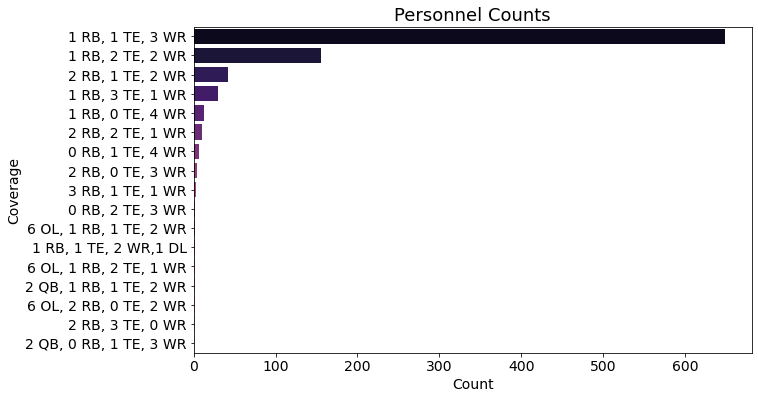

In [34]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['personnelO'].value_counts().index, x=df_plays_final['personnelO'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("Count", fontdict={'fontsize':14});
plt.ylabel("Coverage", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Personnel Counts", fontdict={'fontsize':18});

According to the below, numbers of defenders in the box is 6 most of the time. Very rarely do we see teams go towards the extreme ends of the spectrum and only employ 2 or 9 defenders in the box. This leaves vulnerabilities on opposite ends of the field. If teams leave no defenders in the box, it opens up the run game and if they stack the box with too many players, the passing defense can be easily breached.

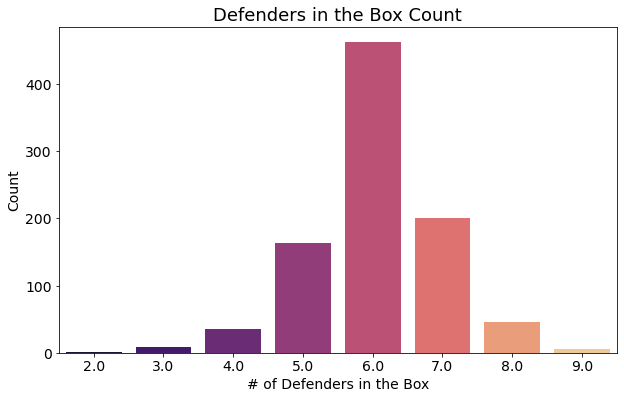

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_plays_final['defendersInTheBox'].value_counts().index, y=df_plays_final['defendersInTheBox'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("# of Defenders in the Box", fontdict={'fontsize':14});
plt.ylabel("Count", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Defenders in the Box Count", fontdict={'fontsize':18});

Number of pass rushers is by far and away 4. Obviously there will be very rare scenarios such as late game scenarios where the defense will send maybe only 2-3. Similar situation to the number of defenders in the box, 4 pass rushers seems to be the most balanced/commonly used option.

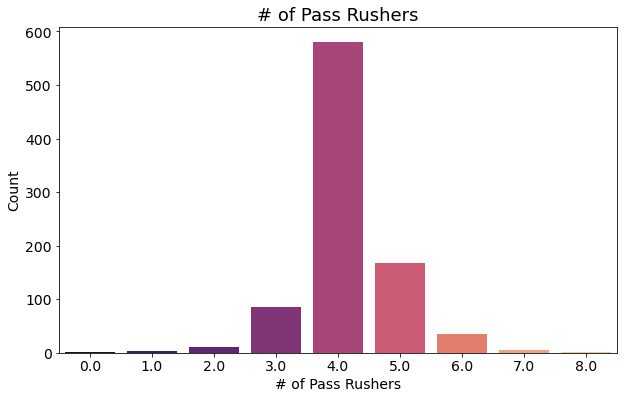

In [36]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_plays_final['numberOfPassRushers'].value_counts().index, y=df_plays_final['numberOfPassRushers'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("# of Pass Rushers", fontdict={'fontsize':14});
plt.ylabel("Count", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("# of Pass Rushers", fontdict={'fontsize':18});

Next, I wanted to see if teams favored any particular personnel set and if they performed better than others. It looked like overall, a lot of teams ran the 4 DL, 2LB, 5DB personnel set due to its flexibility. However, none of those personnel sets are going to be the end all be all solution on the defensive side. The EPA will also once again differ by situation. 

<Figure size 2160x2160 with 0 Axes>

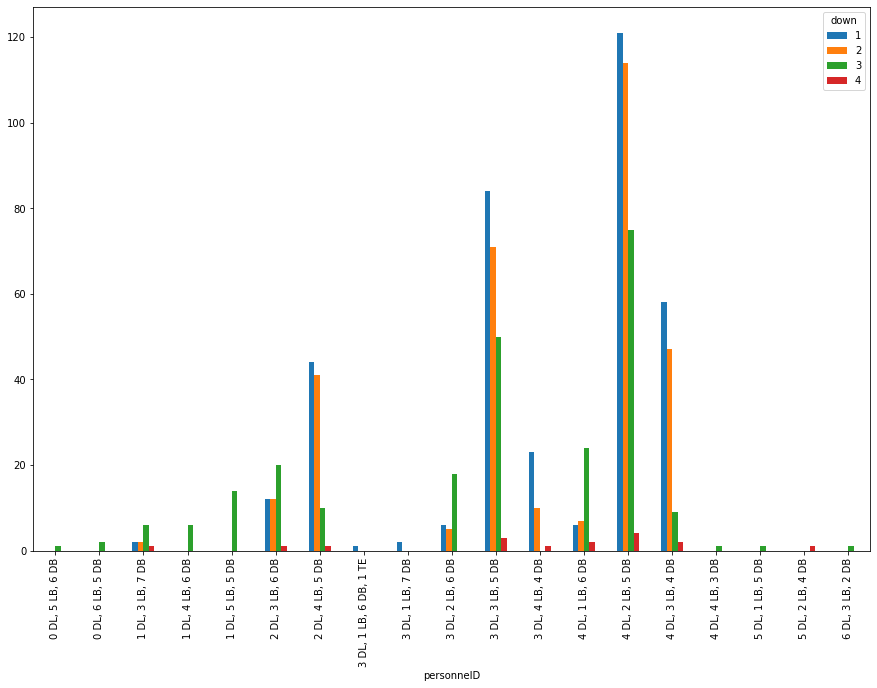

In [37]:
df_plot = df_plays_final.groupby(['personnelD', 'down']).size().unstack(level=1)
plt.figure(figsize=(30,30))
df_plot.plot(kind = 'bar',figsize=(15,10));

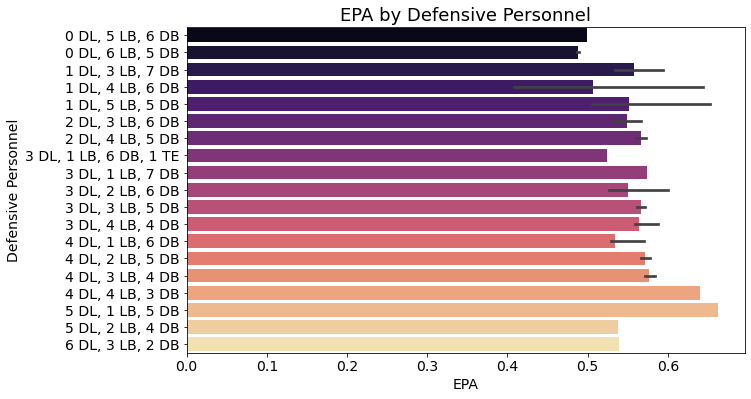

In [38]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['personnelD'].sort_values(), x=df_plays_final['scaled_epa'], estimator=np.median, palette="magma")
plt.xlabel("EPA", fontdict={'fontsize':14});
plt.ylabel("Defensive Personnel", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("EPA by Defensive Personnel", fontdict={'fontsize':18});

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['numberOfPassRushers'].sort_values(), x=df_plays_final['scaled_epa'],orient='h', estimator=np.median,palette="magma")
plt.xlabel("EPA", fontdict={'fontsize':14});
plt.ylabel("# of Rushers", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("# of Rushers", fontdict={'fontsize':18});

Error in callback <function flush_figures at 0x0000012A7F8CBEE0> (for post_execute):


KeyboardInterrupt: 

Do offenses thrive using one particular formation? According to the below, there's no strong favorite for best offensive position. There are also no clear favorites for offensive personnel. 

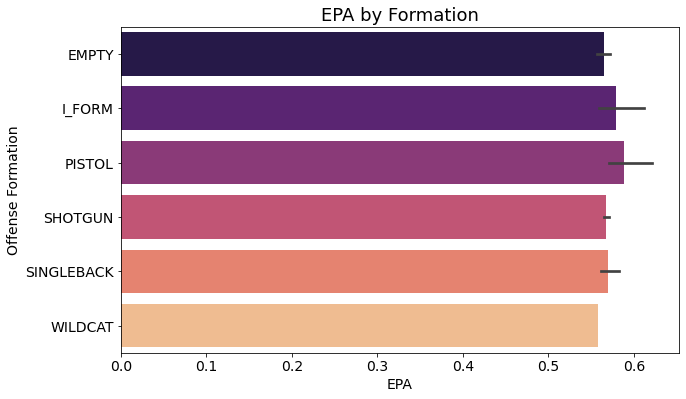

In [40]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['offenseFormation'].sort_values(), x=df_plays_final['scaled_epa'], estimator=np.median,palette="magma")
plt.xlabel("EPA", fontdict={'fontsize':14});
plt.ylabel("Offense Formation", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("EPA by Formation", fontdict={'fontsize':18});

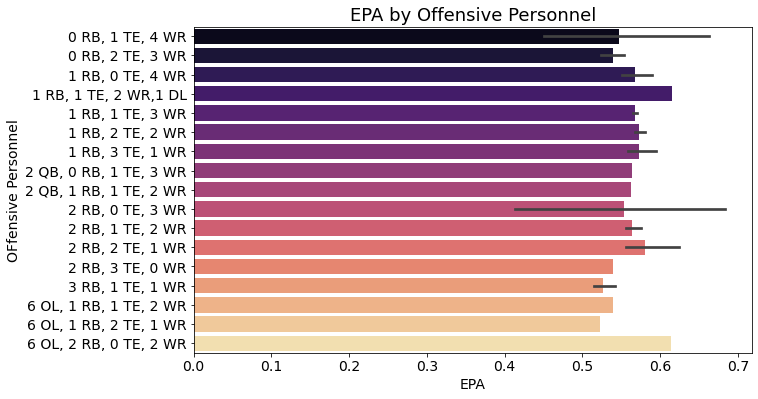

In [41]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['personnelO'].sort_values(), x=df_plays_final['scaled_epa'], estimator=np.median, palette="magma")
plt.xlabel("EPA", fontdict={'fontsize':14});
plt.ylabel("OFfensive Personnel", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("EPA by Offensive Personnel", fontdict={'fontsize':18});

In [42]:
#View Our table 
df_plays_new.head()

,down,yardsToGo,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,scaled_epa,coverage,route,play_id,roof,surface,temp,wind
0,1,15,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",0.593125,Cover 3 Zone,NaN,75,outdoors,grass,81.0,8.0
1,1,10,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",0.562287,Cover 3 Zone,NaN,146,outdoors,grass,81.0,8.0
2,2,10,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0.546221,Cover 3 Zone,NaN,168,outdoors,grass,81.0,8.0
3,3,10,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",0.728582,Cover 3 Zone,NaN,190,outdoors,grass,81.0,8.0
4,3,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",0.539438,Cover 0 Man,NaN,256,outdoors,grass,81.0,8.0


In [43]:
#Create Dummy columns
oform_dummies = pd.get_dummies(df_plays_new['offenseFormation'], drop_first=True)
roof_dummies = pd.get_dummies(df_plays_new['roof'], drop_first=True)
opersonnel_dummies = pd.get_dummies(df_plays_new['personnelO'], drop_first=True)
# dropback_dummies = pd.get_dummies(df_plays_final['typeDropback'],drop_first=True)
coverage_dummies = pd.get_dummies(df_plays_new['coverage'],drop_first=True)
surface_dummies = pd.get_dummies(df_plays_new['surface'], drop_first=True)
df_main = pd.concat([df_plays_new, oform_dummies,opersonnel_dummies,coverage_dummies,roof_dummies,surface_dummies], axis=1)

In [44]:
#View Columns in our new table
df_main.columns

Index(['down', 'yardsToGo', 'offenseFormation', 'personnelO',
       'defendersInTheBox', 'numberOfPassRushers', 'personnelD', 'scaled_epa',
       'coverage', 'route', 'play_id', 'roof', 'surface', 'temp', 'wind',
       'I_FORM', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT',
       '0 RB, 2 TE, 3 WR', '1 RB, 0 TE, 4 WR', '1 RB, 1 TE, 2 WR,1 DL',
       '1 RB, 1 TE, 3 WR', '1 RB, 2 TE, 2 WR', '1 RB, 3 TE, 1 WR',
       '2 QB, 0 RB, 1 TE, 3 WR', '2 QB, 1 RB, 1 TE, 2 WR', '2 RB, 0 TE, 3 WR',
       '2 RB, 1 TE, 2 WR', '2 RB, 2 TE, 1 WR', '2 RB, 3 TE, 0 WR',
       '3 RB, 1 TE, 1 WR', '6 OL, 1 RB, 1 TE, 2 WR', '6 OL, 1 RB, 2 TE, 1 WR',
       '6 OL, 2 RB, 0 TE, 2 WR', 'Cover 1 Man', 'Cover 2 Man', 'Cover 2 Zone',
       'Cover 3 Zone', 'Cover 4 Zone', 'Cover 6 Zone', 'Prevent Zone', 'dome',
       'outdoors', 'grass', 'sportturf'],
      dtype='object')

In [45]:
#Drop old categorical columns
df_main.drop(['personnelD','coverage','personnelO','offenseFormation','route','roof','surface','play_id'], axis=1, inplace=True)

In [46]:
#Drop NA Values, very little in dataset
with pd.option_context('mode.use_inf_as_na', True):
    df_main.dropna(inplace=True,how='all')

In [47]:
#Find Nan Rows
nan_rows = df_main[df_main['temp'].isnull()]

In [48]:
# Replace Nan with Mean for Temp + Wind
df_main['temp'].fillna((df_main['temp'].mean()), inplace=True)
df_main['wind'].fillna((df_main['wind'].mean()), inplace=True)

In [49]:
# Drop NA Values
df_main = df_main.apply (pd.to_numeric, errors='coerce')
df_main = df_main.dropna()

In [50]:
#Check for NA's
df_main.isna().sum()

down                      0
yardsToGo                 0
defendersInTheBox         0
numberOfPassRushers       0
scaled_epa                0
temp                      0
wind                      0
I_FORM                    0
PISTOL                    0
SHOTGUN                   0
SINGLEBACK                0
WILDCAT                   0
0 RB, 2 TE, 3 WR          0
1 RB, 0 TE, 4 WR          0
1 RB, 1 TE, 2 WR,1 DL     0
1 RB, 1 TE, 3 WR          0
1 RB, 2 TE, 2 WR          0
1 RB, 3 TE, 1 WR          0
2 QB, 0 RB, 1 TE, 3 WR    0
2 QB, 1 RB, 1 TE, 2 WR    0
2 RB, 0 TE, 3 WR          0
2 RB, 1 TE, 2 WR          0
2 RB, 2 TE, 1 WR          0
2 RB, 3 TE, 0 WR          0
3 RB, 1 TE, 1 WR          0
6 OL, 1 RB, 1 TE, 2 WR    0
6 OL, 1 RB, 2 TE, 1 WR    0
6 OL, 2 RB, 0 TE, 2 WR    0
Cover 1 Man               0
Cover 2 Man               0
Cover 2 Zone              0
Cover 3 Zone              0
Cover 4 Zone              0
Cover 6 Zone              0
Prevent Zone              0
dome                

## Setup Target Variable

In [51]:
# Our Target Variable is EPA and our features are all the other columns
y = df_main['scaled_epa']
X = df_main.drop(['scaled_epa'], axis=1)

In [52]:
# Also look at the STDEV of our data to see how our RMSE performs over the STDEV.
y.std()

0.07962482709664016

Below is our list of features generated by our initial game situation numbers and categorical variables converted to Dummy columns

In [53]:
# Train Test Split my data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

# scaler = StandardScaler()  
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)  
# X_test = scaler.transform(X_test)

## Run Regression Models

### 1st Model: Linear Regression

First model is a linear regression model. I am currently using the above columns shown in the df_main table as my features. RMSE comes out to about 0.003525629021404673.

In [59]:
# Instantiate Model
linreg = LinearRegression()

# Fit to Training Data
lr_1 = linreg.fit(X_train, y_train)

# Predict on Test Set
y_pred = linreg.predict(X_test)

# Predict on Train Set
y_train_pred = linreg.predict(X_train)

#Calculate MSE/RMSE
mse_train = mean_squared_error(y_train,y_train_pred)
mse = mean_squared_error(y_test,y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
print("RMSE Train: ", mse_train*(1/2.0)) 
print("RMSE/STD: ", mse*(1/2.0)/y.std())

MSE:  0.007051258042809346
RMSE:  0.003525629021404673
RMSE Train:  0.0028892279569141628
RMSE/STD:  0.044278011644855925


In [60]:
kfold = model_selection.KFold(n_splits=10, random_state=100)
linreg = LinearRegression()
results_kfold = model_selection.cross_val_score(linreg, X, y, cv=kfold,scoring='neg_root_mean_squared_error')
print((results_kfold.mean())) 

-0.07880830236126155


C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [61]:
#poly = PolynomialFeatures(degree=2, include_bias=False)
#poly_data = poly.fit_transform(df_features)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(df_poly, target, random_state=9,test_size=0.2)

In [62]:
# # instantiate a linear regression object
# lm_2 = LinearRegression()

# #fit the linear regression to the data
# lm_2 = lm_3.fit(X_train2, y_train2)

# # Predict on Test Set
# y_pred = lm_2.predict(X_test)

# mse = mean_squared_error(y_test,y_pred)
# print("MSE: ", mse)
# print("RMSE: ", mse*(1/2.0)) 

### 2nd Model: DecisionTreeRegression Model

2nd Model was a DecisionTreeRegressor model using the default parameters. RMSE came out to a significantly higher value of 0.019. We will be dropping this model for now. This model also seems to be overfitting to the train set.

In [63]:
kfold = model_selection.KFold(n_splits=10, random_state=100)
DecisionTreeRegModel = DecisionTreeRegressor()
results_kfold = model_selection.cross_val_score(DecisionTreeRegModel, X, y, cv=kfold,scoring='neg_root_mean_squared_error')
print((results_kfold.mean())) 

-0.1080004931167341


C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [64]:
# Instantiate Model
DecisionTreeRegModel = DecisionTreeRegressor()

# Fit to Training Data
DecisionTreeRegModel.fit(X_train, y_train)

# Predict on Train Set
y_train_pred = DecisionTreeRegModel.predict(X_train)

# Predict on Test Set
y_pred = DecisionTreeRegModel.predict(X_test)

#Calculate MSE/RMSE
mse_train = mean_squared_error(y_train,y_train_pred)
mse = mean_squared_error(y_test,y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
print("RMSE Train: ", mse_train*(1/2.0)) 
print("RMSE/STD: ", mse*(1/2.0)/y.std())

MSE:  0.010579573581203656
RMSE:  0.005289786790601828
RMSE Train:  7.641332522454784e-05
RMSE/STD:  0.06643388731232844


### Random Forest Regression Model

In [65]:
kfold = model_selection.KFold(n_splits=10, random_state=100)
rfr = RandomForestRegressor()
results_kfold = model_selection.cross_val_score(rfr, X, y, cv=kfold,scoring='neg_root_mean_squared_error')
print((results_kfold.mean())) 

C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


-0.0829067803029117


In [66]:
# Instantiate Model
rfr = RandomForestRegressor()
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 

# Fit to Training Data
rfr.fit(X_train, y_train)

# Predict on Training Data
y_train_pred = rfr.predict(X_train)

# Predict on Test Set
y_pred = rfr.predict(X_test)

#Calculate MSE/RMSE
mse_train = mean_squared_error(y_train,y_train_pred)
mse = mean_squared_error(y_test,y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
print("RMSE Train: ", mse_train*(1/2.0)) 
print("RMSE/STD: ", mse*(1/2.0)/y.std())

MSE:  0.007882643706553723
RMSE:  0.003941321853276862
RMSE Train:  0.0005990643047051415
RMSE/STD:  0.04949865509275522


### Gradiest Boosting Regressor Model

In [67]:
kfold = model_selection.KFold(n_splits=10, random_state=100)
gbr = GradientBoostingRegressor()
results_kfold = model_selection.cross_val_score(gbr, X, y, cv=kfold,scoring='neg_root_mean_squared_error')
print((results_kfold.mean())) 

C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


-0.081821885876135


In [68]:
# Instantiate Model
gbr = GradientBoostingRegressor()

# Fit to Training Data
gbr.fit(X_train, y_train)

# Predict on Training Data
y_pred = gbr.predict(X_test)

# Predict on Training Data
y_train_pred = gbr.predict(X_train)

#Calculate MSE/RMSE
mse_train = mean_squared_error(y_train,y_train_pred)
mse = mean_squared_error(y_test,y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
print("RMSE Train: ", mse_train*(1/2.0)) 
print("RMSE/STD: ", mse*(1/2.0)/y.std())

MSE:  0.0076743096499463075
RMSE:  0.0038371548249731538
RMSE Train:  0.0019510999645131345
RMSE/STD:  0.048190432116304915


### XGBoost

In [69]:
kfold = model_selection.KFold(n_splits=10, random_state=100)
xgr = xgb.XGBRegressor()
results_kfold = model_selection.cross_val_score(xgr, X, y, cv=kfold,scoring='neg_root_mean_squared_error')
print((results_kfold.mean())) 

C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


-0.09190704933101695


In [70]:
# Instantiate Model
xgr = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Instantiate Model
xgr.fit(X_train,y_train)

# Predict on Training Data
y_train_pred = rfr.predict(X_train)

# Fit to Training Data
y_pred = xgr.predict(X_test)

#Calculate MSE/RMSE
mse_train = mean_squared_error(y_train,y_train_pred)
mse = mean_squared_error(y_test,y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
print("RMSE Train: ", mse_train*(1/2.0)) 
print("RMSE/STD: ", mse*(1/2.0)/y.std())

[01:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
MSE:  0.007780537470208518
RMSE:  0.003890268735104259
RMSE Train:  0.0005990643047051415
RMSE/STD:  0.04885748424147488


### GridSearch

In [ ]:
## Setup Parameters For GridSearch
parameters={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200,500], 
            'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'max_depth': [1,2,3,4,5,6,7,8,9,10], 
            #'min_samples_leaf': [np.linspace(0.1, 1.0, 10, endpoint=True)], 
            'max_features': list(range(1,df_main.shape[1]))} 

In [ ]:
# Run GridSearch
grid_GBR = GridSearchCV(estimator=gbr, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

In [ ]:
# Find Results from GridSearch
print(" Results from GridSearch " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

In [98]:
# Re-run GBR with New Params
gbr = GradientBoostingRegressor(learning_rate= 0.5, max_depth= None, max_features= 13, n_estimators= 1)

# Fit to Training Data
gbr.fit(X_train, y_train)

# Predict on Test Data
y_pred = gbr.predict(X_test)

# Predict on Training Data
y_train_pred = gbr.predict(X_train)

#Calculate MSE/RMSE
mse_train = mean_squared_error(y_train,y_train_pred)
mse = mean_squared_error(y_test,y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
print("RMSE Train: ", mse_train*(1/2.0)) 
print("RMSE/STD: ", mse*(1/2.0)/y.std())

MSE:  0.008687256079899819
RMSE:  0.004343628039949909
RMSE Train:  0.0008472793080690376
RMSE/STD:  0.05455117704278434


In [ ]:
# Setup Parameters for GridSearch on XGR
params = {'learning_rate': [.03, 0.05, .07, 0.10, 0.15], #so called `eta` value
              'max_depth': range (2, 10, 1),
              'min_child_weight': [1, 3, 5, 10],
              'n_estimators': [100,300,500]}

In [ ]:
# Instantiate and Fit on Training Data
grid_xgr = GridSearchCV(estimator=xgr, param_grid = params, cv = 2, n_jobs=-1)
grid_xgr.fit(X_train, y_train)

In [ ]:
# Find reuslts of GridSearch
print(" Results from GridSearch " )
print("\n The best estimator across ALL searched params:\n",grid_xgr.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_xgr.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xgr.best_params_)

In [ ]:
# Re-run XGR with New Params
xgr = xgb.XGBRegressor(             learning_rate=0.05, max_delta_step=0,
                                    max_depth=2, min_child_weight=3,
                                    n_estimators=100)

# Fit to Training Data
xgr.fit(X_train,y_train)

y_pred = xgr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

In [94]:
import pickle

In [102]:
# Pickle our model so we can reopen later
with open('model.pkl','wb') as f:
    pickle.dump(gbr,f)

### View Predictions

In [99]:
# Merge Predictions with Actuals
reset = y_test.reset_index()
df_preds = pd.concat([reset,pd.Series(y_pred)],axis=1).rename(columns={0:'Y Test Preds'})
df_preds

,index,scaled_epa,Y Test Preds
0,126,0.539433,0.567096
1,354,0.568056,0.618297
2,590,0.548218,0.557885
3,509,0.537528,0.600916
4,846,0.678589,0.535237
...,...,...,...
218,882,0.514564,0.610474
219,143,0.293632,0.627903
220,390,0.571126,0.567580
221,622,0.545634,0.573022


## Results

Our most optimal model was the tuned GradientBoostingRegressor model. Although our other models output higher values of RMSE, they were overfitting to our data and were not going to produce ideal results. The results from our GBR model were outputting RMSE values of 0.00357. Our STDEV for our target variable in our dataset was 0.079. Our RMSE / STDEV is 0.0449 showing that our results are fairly good! Our next step will be to create a model output that will allow coaches to utilize our model and input the situations (weather, temperature, on-field players, down, yards to go) to output a recommendation.

### Test Our Model Inputs, Work in Progress

Next Step, develop simple way to input all the below criteria and output an estimated EPA.

In [71]:
# View columns used in our models
df_column_check = df_main.drop(['scaled_epa'], axis=1)
cols = df_column_check.columns.tolist()
cols

['down',
 'yardsToGo',
 'defendersInTheBox',
 'numberOfPassRushers',
 'temp',
 'wind',
 'I_FORM',
 'PISTOL',
 'SHOTGUN',
 'SINGLEBACK',
 'WILDCAT',
 '0 RB, 2 TE, 3 WR',
 '1 RB, 0 TE, 4 WR',
 '1 RB, 1 TE, 2 WR,1 DL',
 '1 RB, 1 TE, 3 WR',
 '1 RB, 2 TE, 2 WR',
 '1 RB, 3 TE, 1 WR',
 '2 QB, 0 RB, 1 TE, 3 WR',
 '2 QB, 1 RB, 1 TE, 2 WR',
 '2 RB, 0 TE, 3 WR',
 '2 RB, 1 TE, 2 WR',
 '2 RB, 2 TE, 1 WR',
 '2 RB, 3 TE, 0 WR',
 '3 RB, 1 TE, 1 WR',
 '6 OL, 1 RB, 1 TE, 2 WR',
 '6 OL, 1 RB, 2 TE, 1 WR',
 '6 OL, 2 RB, 0 TE, 2 WR',
 'Cover 1 Man',
 'Cover 2 Man',
 'Cover 2 Zone',
 'Cover 3 Zone',
 'Cover 4 Zone',
 'Cover 6 Zone',
 'Prevent Zone',
 'dome',
 'outdoors',
 'grass',
 'sportturf']

In [72]:
# Title our App
st.write("""
# Pigskin Playcaller
This app will call your plays!
""")

In [73]:
# Create a sidebar and header
st.sidebar.header('User Input Parameters')

In [74]:
def user_input_features():
    down = st.sidebar.selectbox('Current Down', df_plays_new['down'].unique())
    yardage = st.sidebar.slider('Yards Left to First Down', 0, 100)
    wind = st.sidebar.slider('Wind MPH', 0, 100)
    temp = st.sidebar.slider('Current Temperature', 0, 100)
    roof = st.sidebar.selectbox('Stadium', df_plays_new['roof'].unique())
    formation = st.sidebar.selectbox('Offensive Formation', df_plays_new['offenseFormation'].unique())
    personnelO = st.sidebar.selectbox('Offensive Personnel', df_plays_new['personnelO'].unique())
    surface = st.sidebar.selectbox('Surface', df_plays_new['surface'].unique())
    data = {'down': down,
            'yardsToGo' : yardage,
            'wind' : wind,
            'temp': temp,
            'roof': roof,
            'offenseFormation': formation,
            'personnelO': personnelO,
            'surface': surface}
    features = pd.DataFrame(data, index=[0])
    return features

In [76]:
user_input_features

<function __main__.user_input_features()>

In [77]:
df = user_input_features()

In [78]:
st.subheader('User Input parameters')
st.write(df)

In [79]:
oform_dummies = pd.get_dummies(df['offenseFormation'])
roof_dummies = pd.get_dummies(df['roof'])
opersonnel_dummies = pd.get_dummies(df['personnelO'])
surface_dummies = pd.get_dummies(df['surface'])
df_model = pd.concat([df, oform_dummies,opersonnel_dummies,roof_dummies,surface_dummies], axis=1)

In [80]:
df_run = df_model.reindex(cols, axis=1, fill_value=0)

In [81]:
df_run.at[0,'defendersInTheBox']= 6
df_run.at[0,'numberOfPassRushers']= 4

In [82]:
df_model.drop(['personnelO','offenseFormation','roof','surface'], axis=1, inplace=True)

In [83]:
df_coverages = pd.concat([df_run]*7, ignore_index=True)

In [84]:
df_coverages.at[0,'Cover 1 Man']= 1
df_coverages.at[1,'Cover 2 Man'] = 1
df_coverages.at[2,'Cover 2 Zone'] = 1
df_coverages.at[3,'Cover 3 Zone'] = 1
df_coverages.at[4,'Cover 4 Zone'] = 1
df_coverages.at[5,'Cover 6 Zone'] = 1
df_coverages.at[6,'Prevent Zone'] = 1
df_coverages.rename(index={'0': 'Cover1Man'})

,down,yardsToGo,defendersInTheBox,numberOfPassRushers,temp,wind,I_FORM,PISTOL,SHOTGUN,SINGLEBACK,WILDCAT,"0 RB, 2 TE, 3 WR","1 RB, 0 TE, 4 WR","1 RB, 1 TE, 2 WR,1 DL","1 RB, 1 TE, 3 WR","1 RB, 2 TE, 2 WR","1 RB, 3 TE, 1 WR","2 QB, 0 RB, 1 TE, 3 WR","2 QB, 1 RB, 1 TE, 2 WR","2 RB, 0 TE, 3 WR","2 RB, 1 TE, 2 WR","2 RB, 2 TE, 1 WR","2 RB, 3 TE, 0 WR","3 RB, 1 TE, 1 WR","6 OL, 1 RB, 1 TE, 2 WR","6 OL, 1 RB, 2 TE, 1 WR","6 OL, 2 RB, 0 TE, 2 WR",Cover 1 Man,Cover 2 Man,Cover 2 Zone,Cover 3 Zone,Cover 4 Zone,Cover 6 Zone,Prevent Zone,dome,outdoors,grass,sportturf
0,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
1,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
2,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
3,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
4,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
5,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
6,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0


In [87]:
df_coverages

,down,yardsToGo,defendersInTheBox,numberOfPassRushers,temp,wind,I_FORM,PISTOL,SHOTGUN,SINGLEBACK,WILDCAT,"0 RB, 2 TE, 3 WR","1 RB, 0 TE, 4 WR","1 RB, 1 TE, 2 WR,1 DL","1 RB, 1 TE, 3 WR","1 RB, 2 TE, 2 WR","1 RB, 3 TE, 1 WR","2 QB, 0 RB, 1 TE, 3 WR","2 QB, 1 RB, 1 TE, 2 WR","2 RB, 0 TE, 3 WR","2 RB, 1 TE, 2 WR","2 RB, 2 TE, 1 WR","2 RB, 3 TE, 0 WR","3 RB, 1 TE, 1 WR","6 OL, 1 RB, 1 TE, 2 WR","6 OL, 1 RB, 2 TE, 1 WR","6 OL, 2 RB, 0 TE, 2 WR",Cover 1 Man,Cover 2 Man,Cover 2 Zone,Cover 3 Zone,Cover 4 Zone,Cover 6 Zone,Prevent Zone,dome,outdoors,grass,sportturf
0,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
1,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
2,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
3,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
4,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
5,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
6,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0


In [88]:
x = df_coverages.values

In [100]:
prediction = gbr.predict(x)

In [101]:
prediction

array([0.58471435, 0.62092048, 0.60149033, 0.62092048, 0.62092048,
       0.50529104, 0.62092048])

In [91]:
st.subheader('Prediction')
#st.write(iris.target_names[prediction])
st.write(prediction)

In [92]:
df_coverages['prediction1'] = prediction

In [93]:
df_coverages

,down,yardsToGo,defendersInTheBox,numberOfPassRushers,temp,wind,I_FORM,PISTOL,SHOTGUN,SINGLEBACK,WILDCAT,"0 RB, 2 TE, 3 WR","1 RB, 0 TE, 4 WR","1 RB, 1 TE, 2 WR,1 DL","1 RB, 1 TE, 3 WR","1 RB, 2 TE, 2 WR","1 RB, 3 TE, 1 WR","2 QB, 0 RB, 1 TE, 3 WR","2 QB, 1 RB, 1 TE, 2 WR","2 RB, 0 TE, 3 WR","2 RB, 1 TE, 2 WR","2 RB, 2 TE, 1 WR","2 RB, 3 TE, 0 WR","3 RB, 1 TE, 1 WR","6 OL, 1 RB, 1 TE, 2 WR","6 OL, 1 RB, 2 TE, 1 WR","6 OL, 2 RB, 0 TE, 2 WR",Cover 1 Man,Cover 2 Man,Cover 2 Zone,Cover 3 Zone,Cover 4 Zone,Cover 6 Zone,Prevent Zone,dome,outdoors,grass,sportturf,prediction1
0,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0.632147
1,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0.634795
2,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0.623506
3,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0.632147
4,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0.620720
5,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0.611627
6,1,0,6,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0.617428


In [104]:
low_val = df_coverages[df_coverages['prediction1']==df_coverages['prediction1'].min()]


In [111]:
best_coverage = low_val.loc[:,"Cover 1 Man":"Prevent Zone"].eq(1).idxmax(1)

In [109]:
st.write(best_coverage)

In [110]:
best_coverage

5    Cover 6 Zone
dtype: object